In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [209]:
dataset = pd.read_csv('Leads-data.csv')

In [210]:
dataset.shape

(46608, 15)

# Handling Missing Values

### Dropping Nan and Unusuabe columns

In [211]:
dataset.drop(['id','Agent_id','source','source_city','source_country','utm_source','utm_medium','des_city','des_country','lead_id'
], axis=1 , inplace=True)

In [212]:
dataset.shape

(46608, 5)

### Dropping other values of status other than won and lost

In [213]:
dataset['status'].unique()

array(['LOST', 'WON', 'OPPORTUNITY', 'CONTACTED', 'PROCESSING',
       'IMPORTANT'], dtype=object)

In [214]:
#checking total number of rows with status as lost and won
dataset[dataset['status'] == 'WON'].shape[0] + dataset[dataset['status'] == 'LOST'].shape[0]

46317

In [215]:
df = dataset.loc[dataset['status'].isin(['LOST','WON'])]


In [216]:
#checking if dropping is correct or not
print(df.shape)
print(df['status'].unique())

(46317, 5)
['LOST' 'WON']


### Now, taking count of nan values in remaining columns

In [217]:
features_nan=[feature for feature in dataset.columns if dataset[feature].isnull().sum()>1]

for feature in features_nan:
    print("{}: {} missing values".format(feature,dataset[feature].isnull().sum(),))

lost_reason: 3364 missing values
budget: 3700 missing values
duration: 2341 missing values
room_type: 23540 missing values


since nan values are in significant numbers we can not straight away drop them


### checking effect of nan values on the target variable

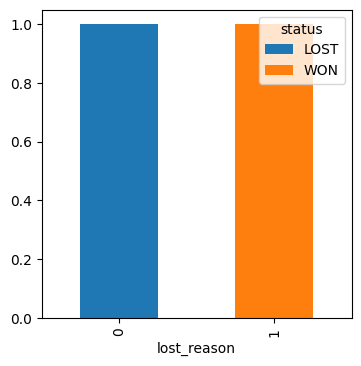

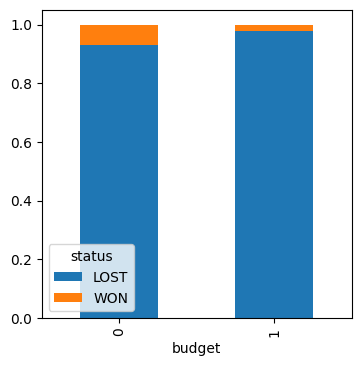

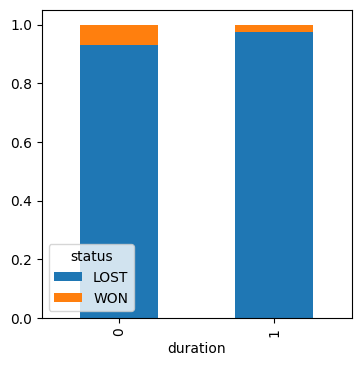

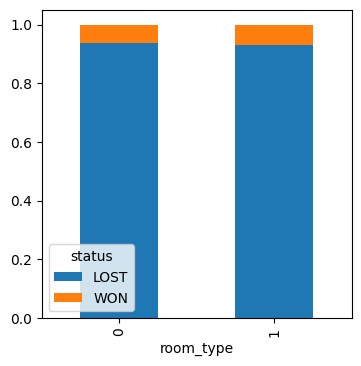

In [218]:
for feature in features_nan:
    data = df.copy()
    data[feature] = np.where(data[feature].isnull(),1,0)
    Gender = pd.crosstab(data[feature],data['status'])
    Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True,figsize=(4,4))
    plt.show()

Since lost_reason ,budget, duration missing values playing a significant role in the target variable we can't drop it <br>
We can drop room_type missing values since it not giving a distinction between LOST and WON values

In [219]:
df.dropna(subset = ['room_type'], inplace=True)

C:\Users\vikas\AppData\Local\Temp\ipykernel_19068\3497526769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ['room_type'], inplace=True)


In [220]:
df.shape

(22833, 5)

### Labeling the missing values so that they can be given weightage in the model training

In [221]:
## Replace missing value with a new label
def replace_cat_feature(dataset,features_nan):
    data=dataset.copy()
    data[features_nan]=data[features_nan].fillna('Missing')
    return data

df =replace_cat_feature(df,features_nan)

df[features_nan].isnull().sum()

lost_reason    0
budget         0
duration       0
room_type      0
dtype: int64

Now we are done with handling missing values and can proceed further

# Feature Engineering

Label encoding for features 

In [222]:
from sklearn.preprocessing import LabelEncoder

#Saving label so that we can use it later to reverse transform in inference script

le1 = LabelEncoder()
df['status'] = le1.fit_transform(df['status'])
output = open('le1.pkl', 'wb')
pickle.dump(le1, output)
output.close()

le2 = LabelEncoder()
df['lost_reason'] = le2.fit_transform(df['lost_reason'])
output = open('le2.pkl', 'wb')
pickle.dump(le2, output)
output.close()


le3 = LabelEncoder()
df['budget'] = le3.fit_transform(df['budget'])
output = open('le3.pkl', 'wb')
pickle.dump(le3, output)
output.close()

le4 = LabelEncoder()
df['duration'] = le4.fit_transform(df['duration'])
output = open('le4.pkl', 'wb')
pickle.dump(le4, output)
output.close()

le5 = LabelEncoder()
df['room_type'] = le5.fit_transform(df['room_type'])
output = open('le5.pkl', 'wb')
pickle.dump(le5, output)
output.close()


In [223]:
df.head()

,status,lost_reason,budget,duration,room_type
2,0,22,284,98,5
7,0,30,320,78,6
11,0,22,284,98,5
12,0,30,284,98,6
13,0,22,320,95,6


Checking correlation of variables

<Axes: >

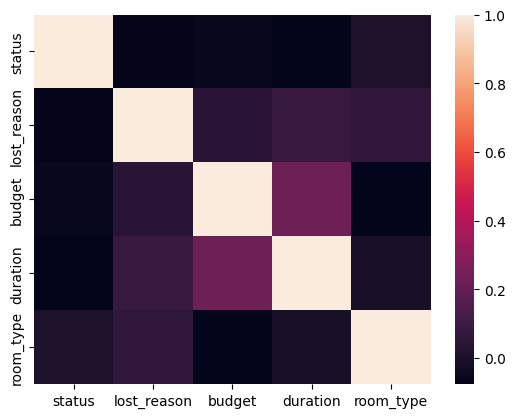

In [224]:
sns.heatmap(df.corr())

## Model creation

In [225]:
y = df['status']
X= df.drop('status',axis=1)

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

Since, we need the probability of the labels as predictions not the labels themself<br>
We will be using the logistic regression as it is the simplest algorithm and use the least computational resources

In [227]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

Checking Probablities of 'LOST' or 'WON'

In [228]:
model.predict_proba(X_test)

array([[0.92719932, 0.07280068],
       [0.94601639, 0.05398361],
       [0.94301972, 0.05698028],
       ...,
       [0.94707079, 0.05292921],
       [0.93929698, 0.06070302],
       [0.92305318, 0.07694682]])

## Packing Model

In [229]:
import pickle

In [230]:
pickle.dump(model,open('Lead.pkl','wb'))